# TOC

* [import libraries and source files](#import-libraries-and-source-files)
* [functions definitions](#functions-for-calculations)
* [looking at average shapes visually](#looking-at-average-shapes-visually)

you could just jump to "looking at average shapes visually" to check the comparsion between a few methods

# import libraries and source files
and get Dataframes needed for calculations

In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [61]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 96

In [3]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--gapminder_gini--by--geo--time.csv'
shapes_file = '../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv'

In [4]:
income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['geo', 'time'])
gini.index.names = ['country', 'time']
shapes = pd.read_csv(shapes_file)

In [5]:
# convert xkx to kos. Same country, but povcal and open-numbers use different code
shapes['country'] = shapes['country'].replace({'xkx': 'kos'})

In [6]:
# create a sorted version
shapes_ = shapes.set_index(['country', 'year']).sort_index()

In [7]:
merge = pd.concat([income, gini], axis=1)

In [8]:
# get all available country/year pair from povcal

unique_country_year = shapes[['country', 'year']].drop_duplicates()

known_income = list()
known_gini = list()

for _, row in unique_country_year.iterrows():
    r = (row['country'], row['year'])
    if r in merge.index:
        i = merge.loc[r, 'mincpcap_cppp']
        g = merge.loc[r, 'gapminder_gini']
    else:
        i = np.nan
        g = np.nan
    known_income.append(i)
    known_gini.append(g)
    
idx = pd.MultiIndex.from_frame(unique_country_year)
known_country_year_df = pd.DataFrame({'income': known_income, 'gini': known_gini}, index=idx)

In [9]:
known_country_year_df

income  gini
country year              
ago     1981  5.5461  53.8
        1982  5.3525  53.7
        1983  5.3818  53.6
        1984  5.5050  53.5
        1985  5.4991  53.4
...              ...   ...
zwe     2015  4.4835  43.2
        2016  4.1485  43.2
        2017  3.9717  43.2
        2018  4.2896  43.2
        2019  4.0536  43.2

[6409 rows x 2 columns]

# functions for calculation

## 1. for selecting in a circle

In [10]:
# calculate distances from one point to all known income/gini points as in 2D plane.
# the distance is calculated by sqrt(gini_distance^2 + income_distance^2)
# and gini_distance and income_distance are standarized so that 1 means +/- 10% 

def get_distances(income, gini):
    """distance in 2D plane"""
    gini_distances = (known_country_year_df['gini'] - gini) / gini * 10
    # income: maybe better to use log scale?
    income_distances = (np.log(known_country_year_df['income']) - np.log(income)) * 10
    # income_distances = (known_country_year_df['income'] - income) / income * 10
    
    
    res = np.sqrt(np.power(income_distances, 2) + 
                  np.power(gini_distances, 2))
    return res.sort_values(ascending=True).dropna()

In [11]:
# for example
get_distances(5.3, 53)

country  year
ago      1982     0.164802
nic      1989     0.179365
ago      1983     0.190458
         1989     0.257413
cpv      1997     0.282925
                   ...    
are      1982    36.599022
         2004    36.651634
         2001    36.855541
         2002    36.937969
         1981    37.895079
Length: 6350, dtype: float64

In [12]:
# TODO: add get_neighbors by rectangle 

In [13]:
# get n neighbor countries
# radius: max distance allowed
# only_once: only include one country for once
# n: max countries allowed
def get_neighbors_n_countries_circle(income, gini, n=5, radius=1.414, only_once=False):
    neis = list()
    ecs = set()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]  # droping res= 0, because exact match means it's same point
    for i, v in res.iteritems():
        if only_once and i[0] in ecs:
            continue
        ecs.add(i[0])
        neis.append(i)
        if len(ecs) >= n:
            break
    if len(ecs) < n:
        print(f'can not get enough countries, only {len(ecs)} countries selected')
    return neis

In [14]:
get_neighbors_n_countries_circle(5.3, 53, 5)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986),
 ('ago', 1987),
 ('ago', 1985),
 ('ago', 1984),
 ('ken', 1992),
 ('ago', 1990),
 ('ago', 1981),
 ('swz', 2013)]

In [15]:
get_neighbors_n_countries_circle(5.3, 53, 5, only_once=True)

[('ago', 1982), ('nic', 1989), ('cpv', 1997), ('ken', 1992), ('swz', 2013)]

In [16]:
# get n neighbor points
# radius: max distance allowed
# n: max points allowed
def get_neighbors_n_points_circle(income, gini, n=10, radius=1.414):
    neis = list()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]
    for i, v in res.iteritems():
        neis.append(i)
        if len(neis) >= n:
            break
    if len(neis) < n:
        print(f'can not get enough points, only {len(neis)} points selected')
    return neis

In [17]:
get_neighbors_n_points_circle(5.3, 53, 5)

[('ago', 1982), ('nic', 1989), ('ago', 1983), ('ago', 1989), ('cpv', 1997)]

In [18]:
get_neighbors_n_points_circle(5.3, 53, 6)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986)]

## 2. for selecting within a rectangle

In [73]:
kcy = known_country_year_df.dropna(how='any').copy()
kcy.columns =  ['income', 'gini']
kcy['income'] = np.log2(kcy['income'])

In [75]:
p1 = kcy['income'] > np.log2(5.3) - 1
p2 = kcy['income'] < np.log2(5.3) + 1

p3 = kcy['gini'] > 53 - 1
p4 = kcy['gini'] < 53 + 1

kcy[p1 & p2 & p3 & p4].index.values

array([('ago', 1981), ('ago', 1982), ('ago', 1983), ('ago', 1984),
       ('ago', 1985), ('ago', 1986), ('ago', 1987), ('ago', 1988),
       ('ago', 1989), ('ago', 1990), ('ago', 1991), ('ago', 1992),
       ('ago', 1993), ('ago', 1994), ('ago', 1995), ('ago', 1996),
       ('ago', 1997), ('ago', 1998), ('ago', 1999), ('blz', 2000),
       ('blz', 2001), ('blz', 2002), ('blz', 2003), ('blz', 2004),
       ('blz', 2005), ('blz', 2006), ('blz', 2007), ('blz', 2008),
       ('blz', 2009), ('blz', 2010), ('blz', 2011), ('blz', 2012),
       ('blz', 2013), ('blz', 2014), ('blz', 2015), ('blz', 2016),
       ('blz', 2017), ('blz', 2018), ('blz', 2019), ('bol', 1995),
       ('col', 1982), ('col', 1983), ('col', 1984), ('col', 1985),
       ('col', 1993), ('com', 2004), ('com', 2005), ('com', 2006),
       ('com', 2007), ('cpv', 1985), ('cpv', 1986), ('cpv', 1987),
       ('cpv', 1988), ('cpv', 1989), ('cpv', 1990), ('cpv', 1991),
       ('cpv', 1992), ('cpv', 1993), ('cpv', 1994), ('cpv', 19

In [30]:
def get_neighbors_rectangle(income, gini, plus_minus=2, n=0):
    p1 = kcy['income'] > income - plus_minus
    p2 = kcy['income'] < income + plus_minus
    
    p3 = kcy['gini'] > gini - plus_minus
    p4 = kcy['gini'] < gini + plus_minus
    
    return kcy[p1 & p2 & p3 & p4].index.tolist()

In [31]:
get_neighbors_rectangle(5.3, 53, 1)

[('ago', 1981),
 ('ago', 1982),
 ('ago', 1983),
 ('ago', 1984),
 ('ago', 1985),
 ('ago', 1986),
 ('ago', 1987),
 ('ago', 1988),
 ('ago', 1989),
 ('ago', 1990),
 ('ago', 1991),
 ('ago', 1992),
 ('cpv', 1995),
 ('cpv', 1996),
 ('cpv', 1997),
 ('cpv', 1998),
 ('cpv', 1999),
 ('gtm', 1981),
 ('hnd', 1992),
 ('hnd', 1993),
 ('ken', 1992),
 ('nic', 1989),
 ('nic', 1990),
 ('nic', 1991),
 ('nic', 1992),
 ('nic', 1993),
 ('nic', 1994),
 ('nic', 1995)]

In [76]:
def get_neighbors_rectangle2(income, gini, delta_i=2, delta_g=2):
    
    if not delta_i and not delta_g:
        return kcy.index.tolist()
    
    income = np.log(income)
    
    if delta_i:    
        p1 = kcy['income'] > income - delta_i
        p2 = kcy['income'] < income + delta_i
        if delta_g:    
            p3 = kcy['gini'] > gini - delta_g
            p4 = kcy['gini'] < gini + delta_g    
            return kcy[p1 & p2 & p3 & p4].index.tolist()
        else:
            return kcy[p1 & p2].index.tolist()
    else:
        p3 = kcy['gini'] > gini - delta_g
        p4 = kcy['gini'] < gini + delta_g    
        return kcy[p3 & p4].index.tolist()

In [81]:
kcy['income'].describe()

count    6350.000000
mean        3.040264
std         1.489956
min        -0.526992
25%         1.867412
50%         2.986584
75%         4.059868
max         7.861632
Name: income, dtype: float64

## 3. others

In [32]:
def get_income_gini(idx):
    i = merge.loc[idx, 'mincpcap_cppp']
    g = merge.loc[idx, 'gapminder_gini']
    return i, g

In [33]:
# function for merging shapes
# s_list: a list of shapes objects (pd.Series)
def merge_nshapes(s_list):
    n = len(s_list)
    res = pd.concat(s_list, axis=1).fillna(0)
    return res.mean(axis=1)

In [64]:
# get shape from known shapes
def get_shape(idx):
    df = shapes_.loc[idx]
    for t in 'naur':
        if t in df['coverage_type'].values:
#             if t in 'ur':
#                 print(f'{idx}: using urban/rural data')
            df_nc = df[df['coverage_type'] == t]
            df_nc = df_nc.set_index('bracket')['population_percentage']
            return df_nc

In [35]:
def get_estimated_shape(idx, method, use_known_shape=False, **kwargs):
    # 1. if the idx is in known shapes and use_known_shape=True, just return the known shape
    # 2. if not, return the estimated shape by given method. kwargs will be used as the given
    # method's parameters.
    if idx in shapes_.index:
        if use_known_shape:
            return get_shape(idx)
        else:
            i, g = get_income_gini(idx)
            nei = method(i, g, **kwargs)
            nei = [x for x in nei if x != idx]  # remove itself from neighbours
            print(f'using {len(nei)} shapes')
            # print(nei)
            slist = list(map(get_shape, nei))
            return merge_nshapes(slist)
    else:
        i, g = get_income_gini(idx)
        nei = method(i, g, **kwargs)
        print(f'using {len(nei)} shapes')
        slist = list(map(get_shape, nei))
        return merge_nshapes(slist)

In [37]:
# example usage:
x = ('usa', 1990)
i, g = get_income_gini(x)
res1 = get_shape(x)
res2 = get_estimated_shape(x, get_neighbors_n_countries_circle, n=10)

can not get enough countries, only 4 countries selected
using 30 shapes


In [38]:
# function for telling difference between estimated and actual shapes
def mean_square_for_2shapes(s1, s2):
    s1_, s2_ = s1.align(s2)
    rms = np.sqrt(np.sum(np.power(s1_ - s2_, 2)))
    return rms

In [39]:
mean_square_for_2shapes(res1, res2)

0.012895856884200349

# looking at average shapes visually

Below are some examples for comparsion between estimated shapes and actual shapes using different neighbor selecting approaches. 

Please Note:
1. the distance is calculated as in 2D plane: sqrt(gini_distance^2 + income_distance^2), 
    - and gini_distance and income_distance are standarized so that 1 means +/-10%. 
    - Below examples we are selecting neighbors in circles using radius=sqrt(2), 
    - which means for a given (gini, income) pair, the neighbors' gini will be in the range (gini - 10%, gini + 10%) and so as to income.
    

In [40]:
def do_plot(x, ns, method, **kwargs):
    i, g = get_income_gini(x)
    print(x)
    print(f"i = {i}, g = {g}")
    res1 = get_shape(x)
    
    for i, n in enumerate(ns):
        print(f'n = {n}')
        plt.subplot(2, 2, i+1)
        res2 = get_estimated_shape(x, method, n=n, **kwargs)
        rms = mean_square_for_2shapes(res1, res2)
        plt.plot(res1, label='actual')
        plt.plot(res2, label='estimated')
        plt.title(f"n={n}, rms={rms:.6f}")
        plt.legend()

In [41]:
def do_plot2(x, ns, method, **kwargs):
    i, g = get_income_gini(x)
    print(x)
    print(f"i = {i}, g = {g}")
    res1 = get_shape(x)
    
    for i, n in enumerate(ns):
        print(f'n = {n}')
        plt.subplot(2, 2, i+1)
        res2 = get_estimated_shape(x, method, plus_minus=n, **kwargs)
        rms = mean_square_for_2shapes(res1, res2)
        plt.plot(res1, label='actual')
        plt.plot(res2, label='estimated')
        plt.title(f"n={n}, rms={rms:.6f}")
        plt.legend()

## example 1: swe 2015

### 1. N countries, no repeating

('swe', 2015)
i = 55.2617, g = 28.8
n = 5
using 5 shapes
n = 10
using 10 shapes
n = 15
can not get enough countries, only 14 countries selected
using 14 shapes
n = 20
can not get enough countries, only 14 countries selected
using 14 shapes


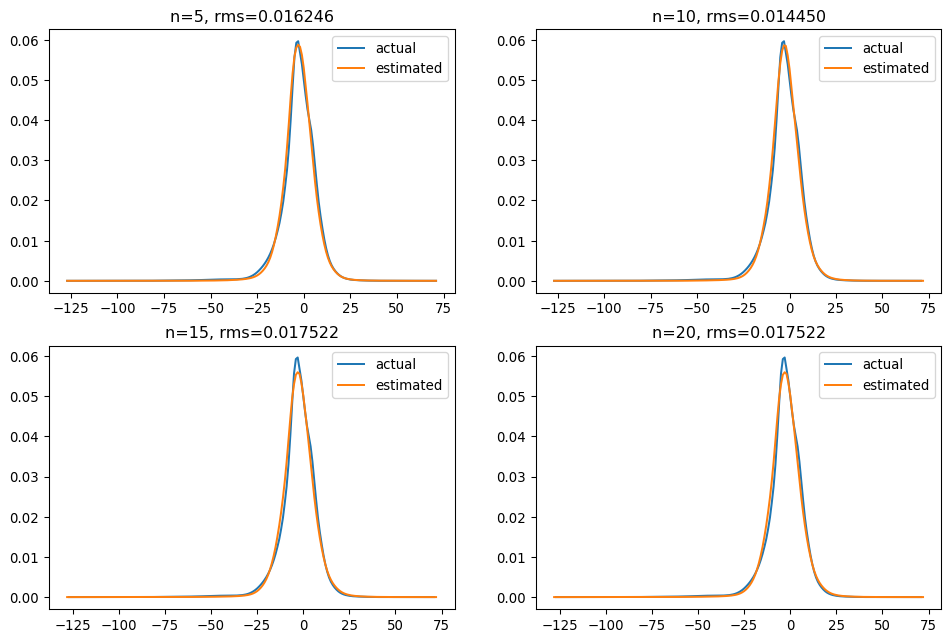

In [28]:
ns = [5, 10, 15, 20]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)  # one country only exist once in neighbor list

## 2. N countries, allow multiple occurrences

('swe', 2015)
i = 55.2617, g = 28.8
n = 5
using 7 shapes
n = 10
using 56 shapes
n = 15
can not get enough countries, only 14 countries selected
using 151 shapes
n = 20
can not get enough countries, only 14 countries selected
using 151 shapes


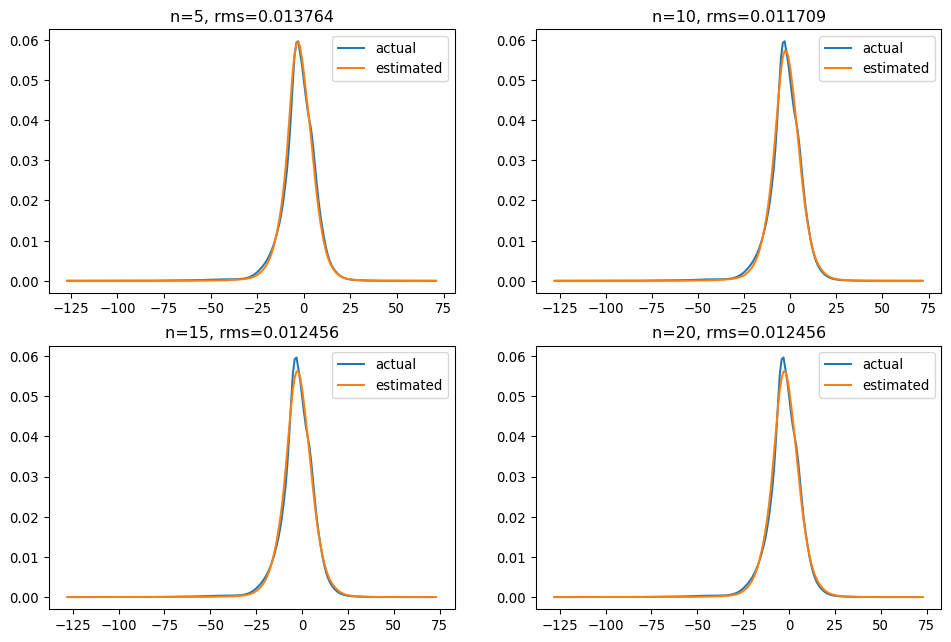

In [29]:
ns = [5, 10, 15, 20]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points

('swe', 2015)
i = 55.2617, g = 28.8
n = 10
using 10 shapes
n = 20
using 20 shapes
n = 40
using 40 shapes
n = 80
using 80 shapes


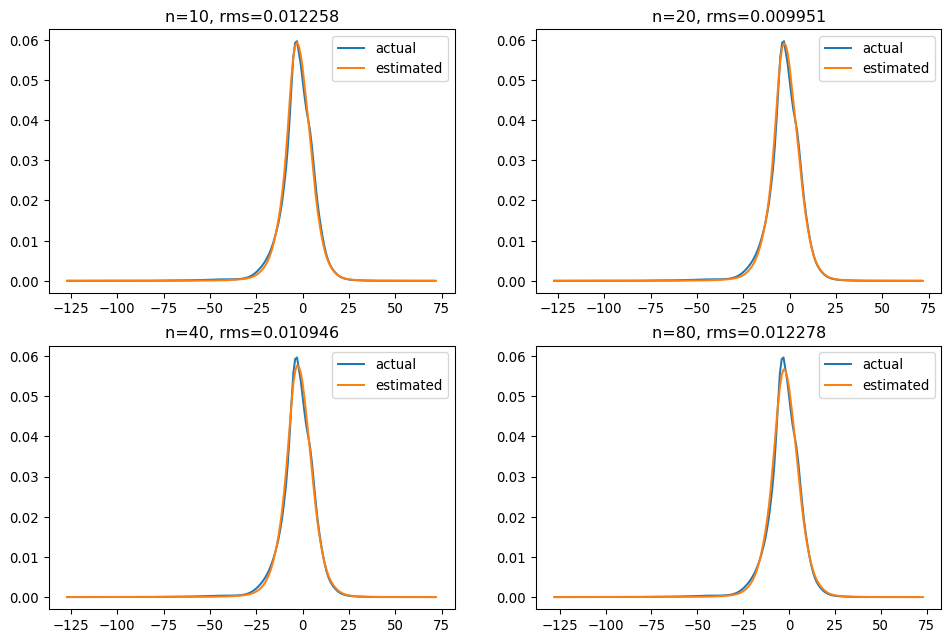

In [30]:
ns = [10, 20, 40, 80]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_points)

## example 2: Brazil 1990

### 1. N countries, no repeating

('bra', 1990)
i = 9.4026, g = 59.0
n = 5
using 5 shapes
('sur', 2001): using urban/rural data
n = 10
using 10 shapes
('sur', 2001): using urban/rural data
n = 15
using 15 shapes
('sur', 2001): using urban/rural data
n = 20
can not get enough countries, only 18 countries selected
using 18 shapes
('sur', 2001): using urban/rural data
('arg', 2002): using urban/rural data


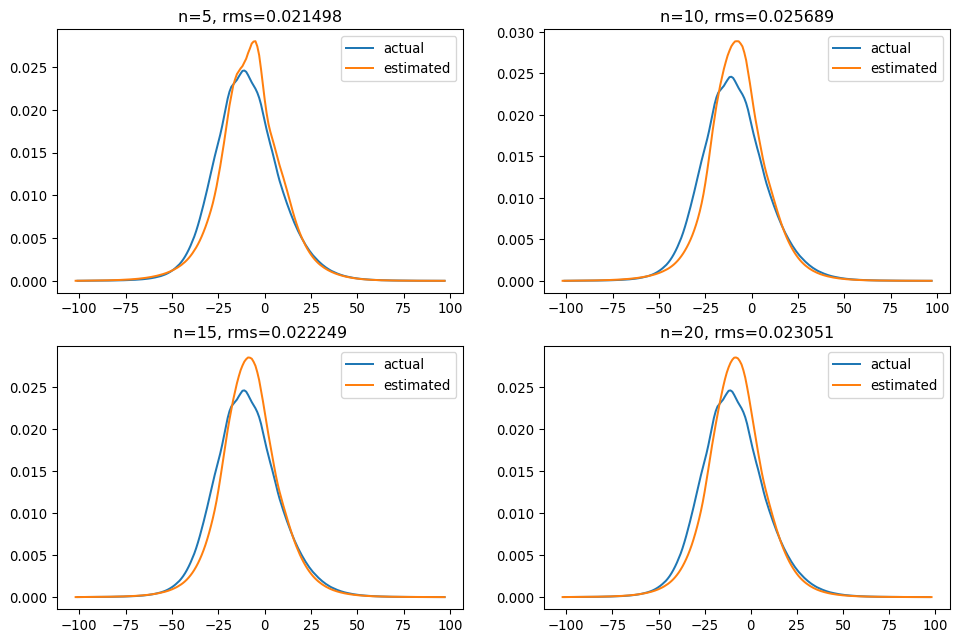

In [31]:
ns = [5, 10, 15, 20]
x = ('bra', 1990)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)

## 2. N countries, allow multiple occurrences

('bra', 1990)
i = 9.4026, g = 59.0
n = 5
using 7 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
n = 10
using 20 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
n = 15
using 95 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
('sur', 1994): using urban/rural data
('sur', 1995): using urban/rural data
('sur', 1996): using urban/rural data
('sur', 1992): using urban/rural data
('sur', 2003): using urban/rural data
('sur', 1993): using urban/rural data
('sur', 1991): using urban/rural data
('sur', 1990): using urban/rural data
('sur', 1987): using urb

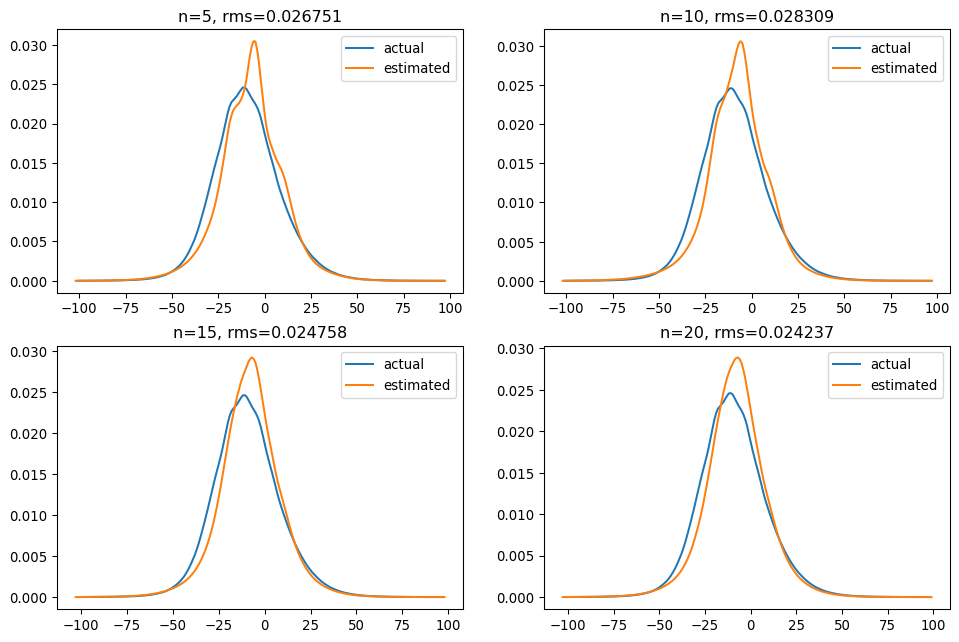

In [32]:
ns = [5, 10, 15, 20]
x = ('bra', 1990)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points

('bra', 1990)
i = 9.4026, g = 59.0
n = 10
using 10 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
n = 20
using 20 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
n = 40
using 40 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
('sur', 1994): using urban/rural data
('sur', 1995): using urban/rural data
('sur', 1996): using urban/rural data
n = 80
using 80 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data

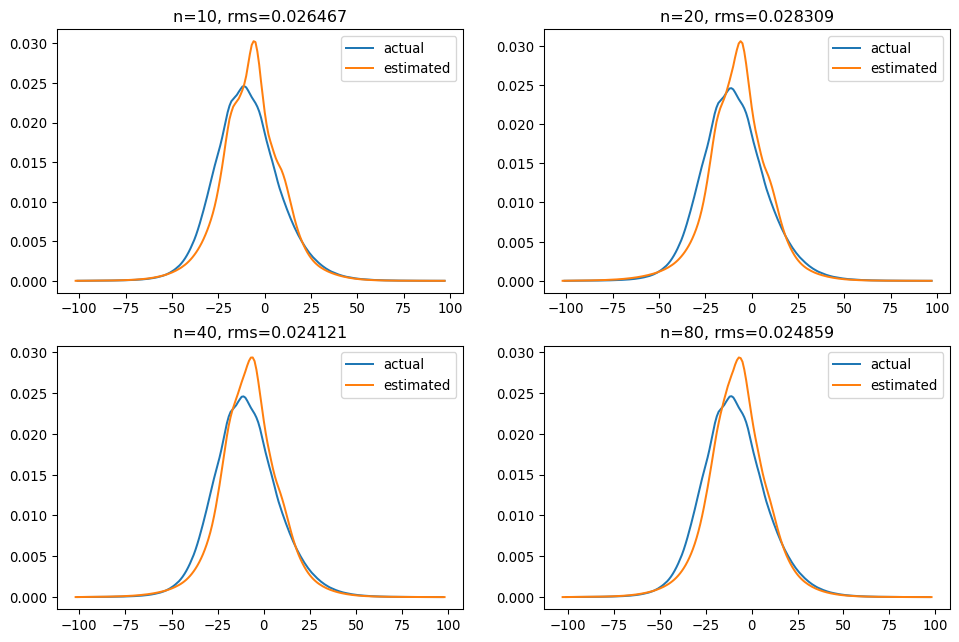

In [33]:
ns = [10, 20, 40, 80]
x = ('bra', 1990)


do_plot(x, ns, get_neighbors_n_points)

### 4. all shapes within a rectangle

('bra', 1990)
i = 9.4026, g = 59.0
n = 0.5
using 1 shapes
n = 1
using 13 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2003): using urban/rural data
n = 2
using 65 shapes
('sur', 1998): using urban/rural data
('sur', 1999): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2003): using urban/rural data
('sur', 2004): using urban/rural data
('sur', 2005): using urban/rural data
n = 5
using 302 shapes
('sur', 1988): using urban/rural data
('sur', 1989): using urban/rural data
('sur', 1990): using urban/rural data
('sur', 1991): using urban/rural data
('sur', 1992): using urban/rural data
('sur', 1993): using urban/rural data
('sur', 1994): using urban/rural data
('sur', 1995): using urban/rural data
('sur', 1996): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1999): using urban/rural data
(

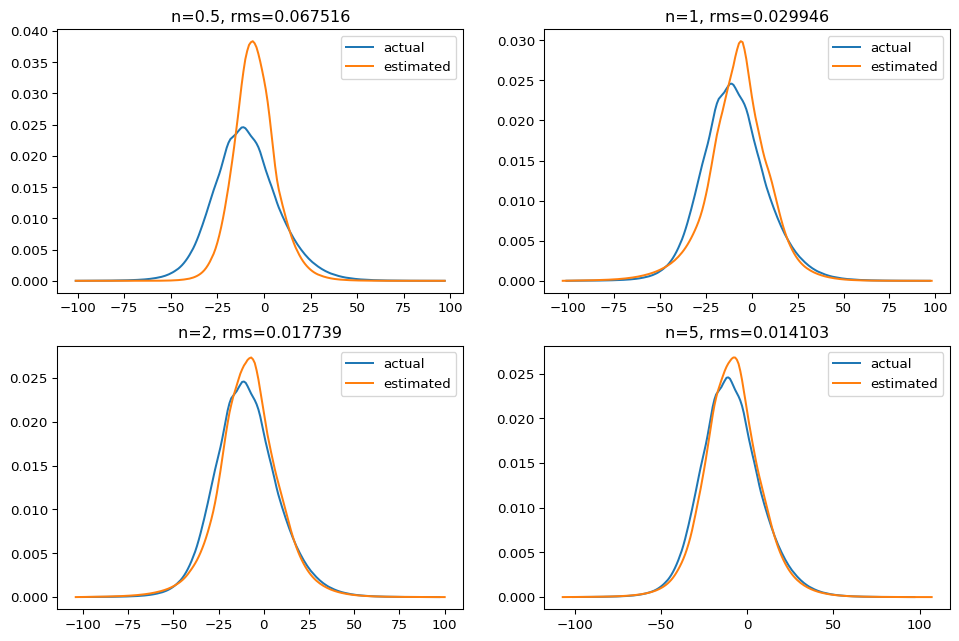

In [42]:
ns = [0.5, 1, 2, 5]
x = ('bra', 1990)


do_plot2(x, ns, get_neighbors_rectangle)

# example 3: Malawi 1991

This shape seems to be special. Because high gini countries' shapes are usually wide

### 1. N countries, no repeating

('mwi', 1991)
i = 3.452, g = 61.0
n = 5
using 5 shapes
n = 10
using 10 shapes
n = 15
can not get enough countries, only 10 countries selected
using 10 shapes
n = 20
can not get enough countries, only 10 countries selected
using 10 shapes


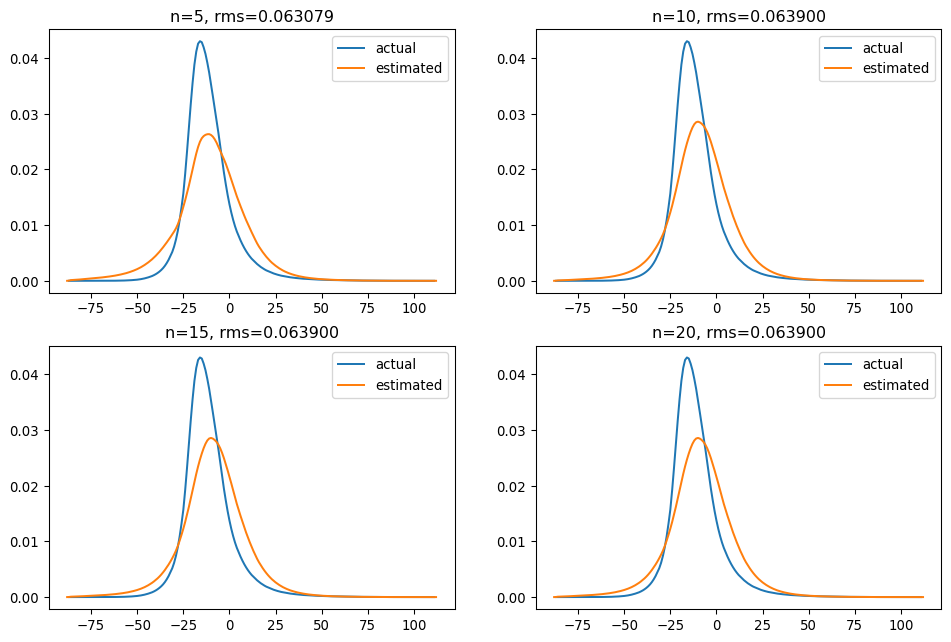

In [34]:
ns = [5, 10, 15, 20]
x = ('mwi', 1991)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)

## 2. N countries, allow multiple occurrences

('mwi', 1991)
i = 3.452, g = 61.0
n = 5
using 26 shapes
n = 10
using 58 shapes
n = 15
can not get enough countries, only 10 countries selected
using 58 shapes
n = 20
can not get enough countries, only 10 countries selected
using 58 shapes


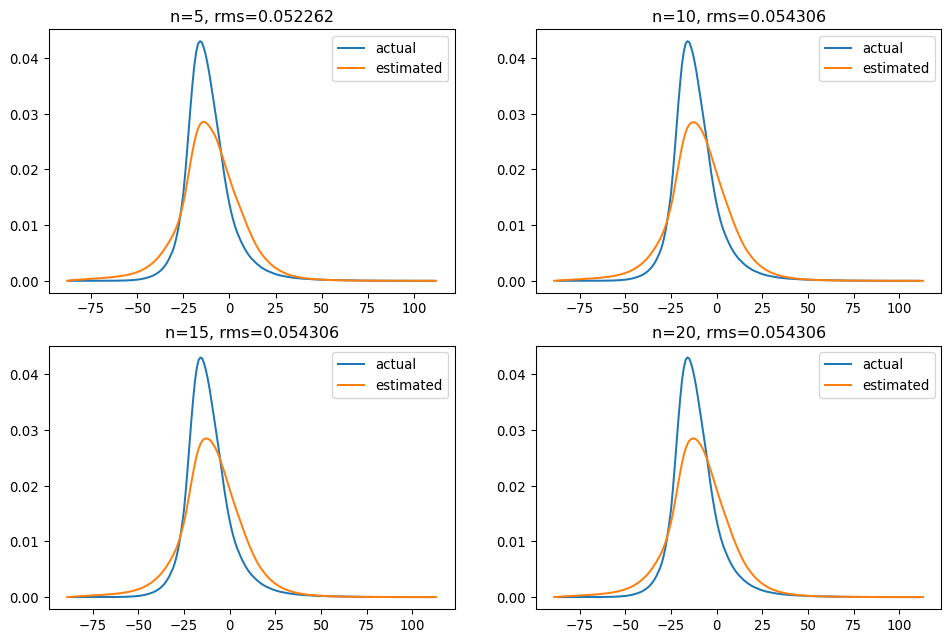

In [35]:
ns = [5, 10, 15, 20]
x = ('mwi', 1991)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points


('mwi', 1991)
i = 3.452, g = 61.0
n = 10
using 10 shapes
n = 20
using 20 shapes
n = 40
using 40 shapes
n = 80
can not get enough points, only 58 points selected
using 58 shapes


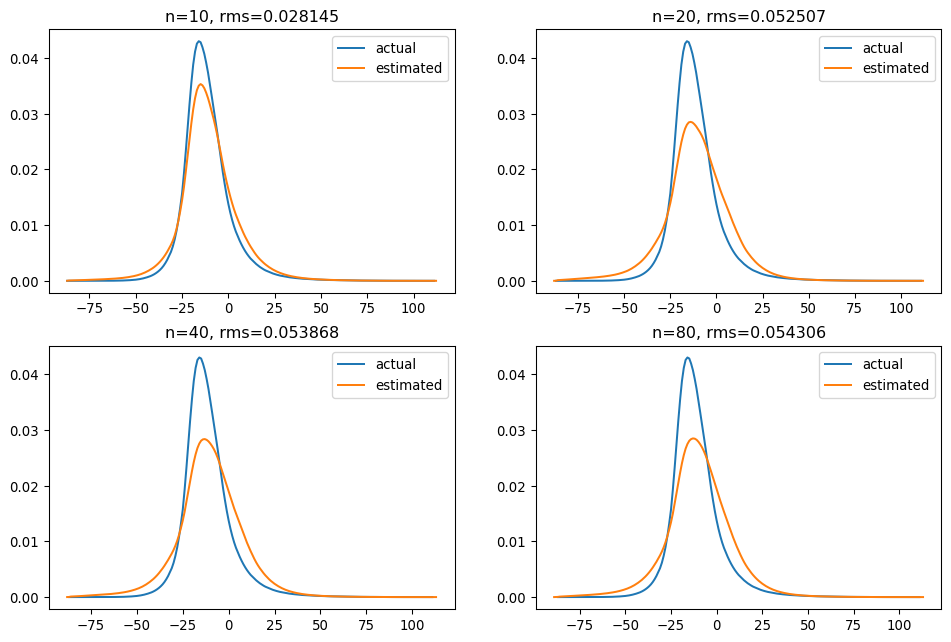

In [36]:
ns = [10, 20, 40, 80]
x = ('mwi', 1991)


do_plot(x, ns, get_neighbors_n_points)

### 4. all shapes within a rectangle

('mwi', 1991)
i = 3.452, g = 61.0
n = 0.5
using 2 shapes
n = 1
using 12 shapes
n = 2
using 32 shapes
n = 5
using 221 shapes


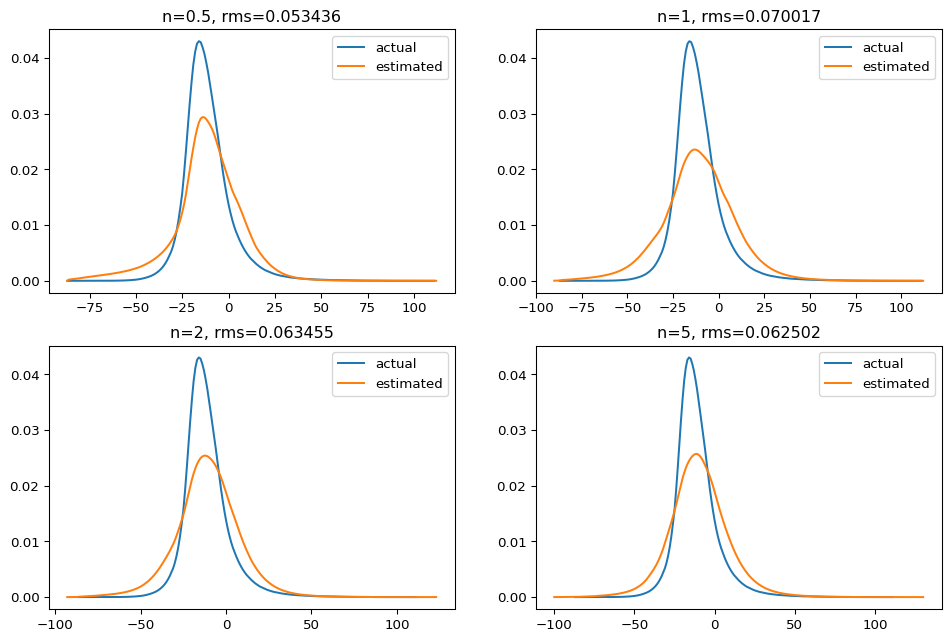

In [43]:
ns = [0.5, 1, 2, 5]
x = ('mwi', 1991)


do_plot2(x, ns, get_neighbors_rectangle)

## question: is gini more sensitive or income more sensitive?

In [59]:
def do_plot3(x, ns, method, **kwargs):
    i, g = get_income_gini(x)
    print(x)
    print(f"i = {i}, g = {g}")
    res1 = get_shape(x)
    
    for i, n in enumerate(ns):          
        di, dg = n
        print(f'delta_i = {di}, delta_g = {dg}')
        plt.subplot(3, 3, i+1)
        res2 = get_estimated_shape(x, method, delta_i=di, delta_g=dg, **kwargs)
        rms = mean_square_for_2shapes(res1, res2)
        plt.plot(res1, label='actual')
        plt.plot(res2, label='estimated')
        plt.title(f"delta_i={di}, delta_g={dg}")
        plt.legend()

('mwi', 1991)
i = 3.452, g = 61.0
delta_i = 0.2, delta_g = None
using 513 shapes
delta_i = 0.5, delta_g = None
using 1153 shapes
delta_i = 1, delta_g = None
using 2000 shapes
delta_i = None, delta_g = 2
using 144 shapes
delta_i = 0.5, delta_g = 2
using 8 shapes
delta_i = 1, delta_g = 2
using 39 shapes
delta_i = None, delta_g = 5
using 355 shapes
delta_i = 0.5, delta_g = 5
using 47 shapes
delta_i = 1, delta_g = 5
using 113 shapes


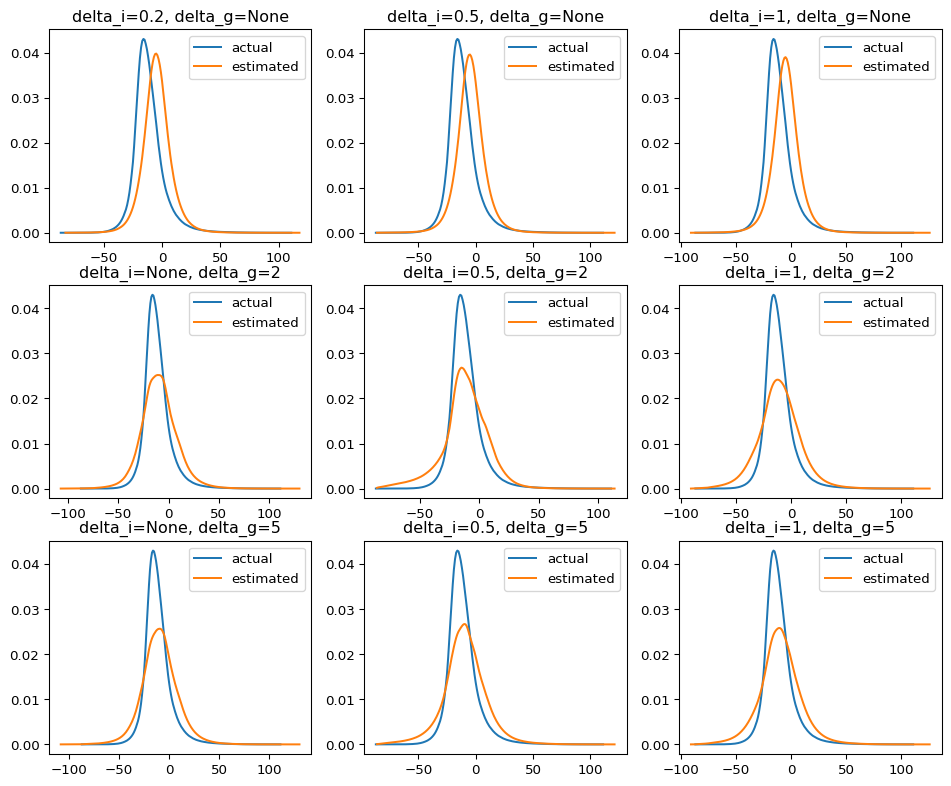

In [82]:
ns = [
    (0.2, None),
    (0.5, None),
    (1, None),
    (None, 2),
    (0.5, 2),
    (1, 2),
    (None, 5),
    (0.5, 5),
    (1, 5)
]
x = ('mwi', 1991)


do_plot3(x, ns, get_neighbors_rectangle2)

('bra', 1990)
i = 9.4026, g = 59.0
delta_i = 0.2, delta_g = None
using 513 shapes
delta_i = 0.5, delta_g = None
using 1335 shapes
delta_i = 1, delta_g = None
using 2926 shapes
delta_i = None, delta_g = 2
using 188 shapes
delta_i = 0.5, delta_g = 2
using 43 shapes
delta_i = 1, delta_g = 2
using 112 shapes
delta_i = None, delta_g = 5
using 492 shapes
delta_i = 0.5, delta_g = 5
using 104 shapes
delta_i = 1, delta_g = 5
using 275 shapes


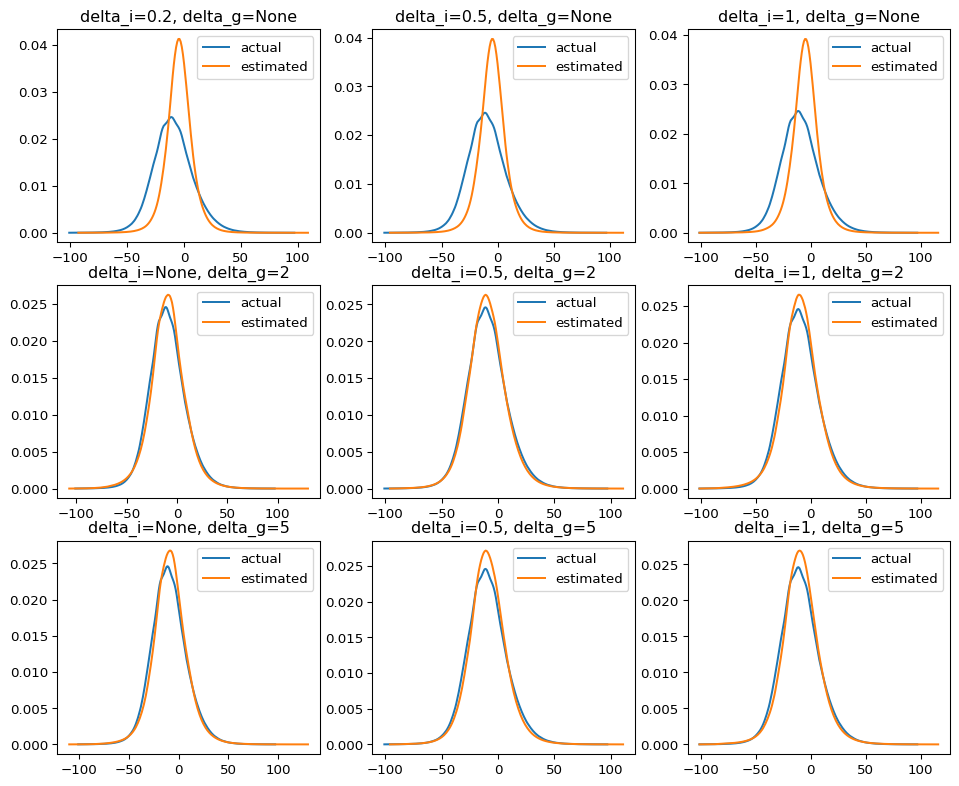

In [83]:
ns = [
    (0.2, None),
    (0.5, None),
    (1, None),
    (None, 2),
    (0.5, 2),
    (1, 2),
    (None, 5),
    (0.5, 5),
    (1, 5)
]
x = ('bra', 1990)


do_plot3(x, ns, get_neighbors_rectangle2)

('swe', 2015)
i = 55.2617, g = 28.8
delta_i = 0.2, delta_g = None
using 423 shapes
delta_i = 0.5, delta_g = None
using 1113 shapes
delta_i = 1, delta_g = None
using 2301 shapes
delta_i = None, delta_g = 2
using 730 shapes
delta_i = 0.5, delta_g = 2
using 135 shapes
delta_i = 1, delta_g = 2
using 255 shapes
delta_i = None, delta_g = 5
using 1862 shapes
delta_i = 0.5, delta_g = 5
using 316 shapes
delta_i = 1, delta_g = 5
using 597 shapes


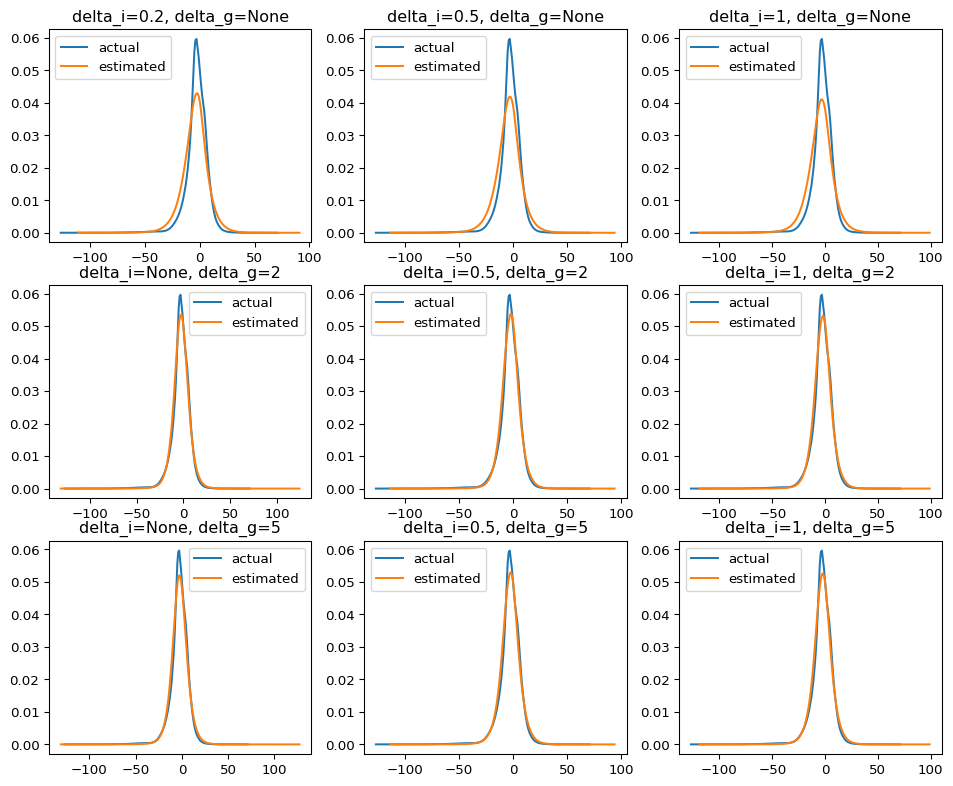

In [84]:
ns = [
    (0.2, None),
    (0.5, None),
    (1, None),
    (None, 2),
    (0.5, 2),
    (1, 2),
    (None, 5),
    (0.5, 5),
    (1, 5)
]
x = ('swe', 2015)


do_plot3(x, ns, get_neighbors_rectangle2)

('tjk', 2000)
i = 2.7311, g = 30.9
delta_i = 0.2, delta_g = None
using 388 shapes
delta_i = 0.5, delta_g = None
using 948 shapes
delta_i = 1, delta_g = None
using 1729 shapes
delta_i = None, delta_g = 2
using 935 shapes
delta_i = 0.5, delta_g = 2
using 89 shapes
delta_i = 1, delta_g = 2
using 174 shapes
delta_i = None, delta_g = 5
using 2284 shapes
delta_i = 0.5, delta_g = 5
using 248 shapes
delta_i = 1, delta_g = 5
using 464 shapes


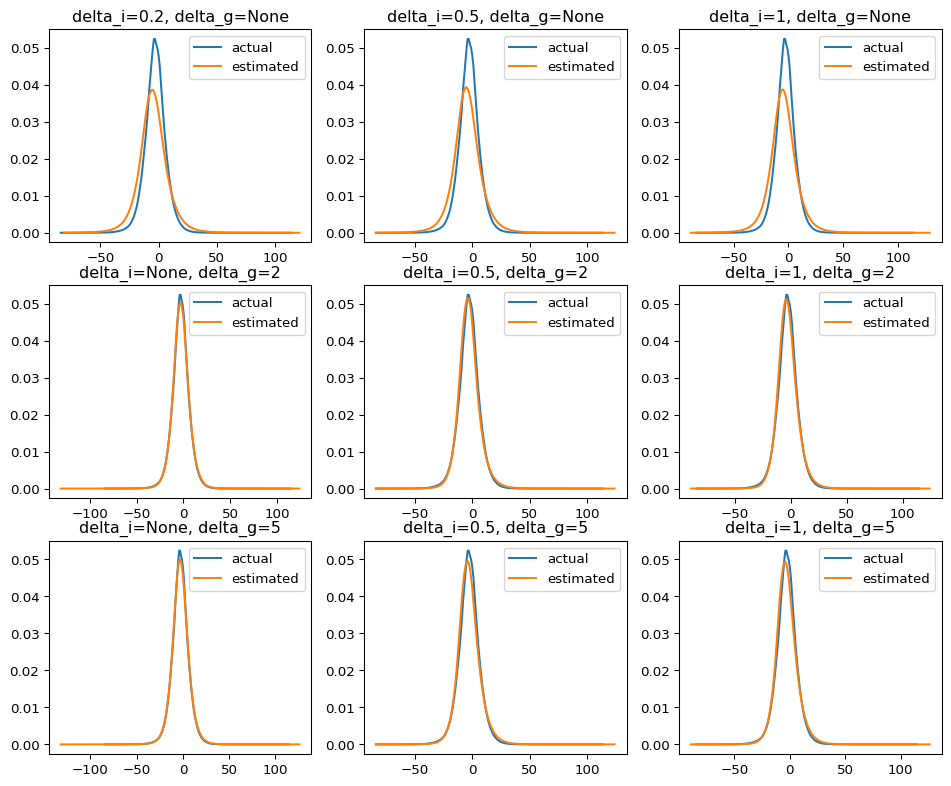

In [85]:
ns = [
    (0.2, None),
    (0.5, None),
    (1, None),
    (None, 2),
    (0.5, 2),
    (1, 2),
    (None, 5),
    (0.5, 5),
    (1, 5)
]
x = ('tjk', 2000)


do_plot3(x, ns, get_neighbors_rectangle2)

('caf', 1993)
i = 1.2222, g = 60.2
delta_i = 0.2, delta_g = None
using 72 shapes
delta_i = 0.5, delta_g = None
using 238 shapes
delta_i = 1, delta_g = None
using 702 shapes
delta_i = None, delta_g = 2
using 165 shapes
delta_i = 0.5, delta_g = 2
using 20 shapes
delta_i = 1, delta_g = 2
using 23 shapes
delta_i = None, delta_g = 5
using 396 shapes
delta_i = 0.5, delta_g = 5
using 28 shapes
delta_i = 1, delta_g = 5
using 48 shapes


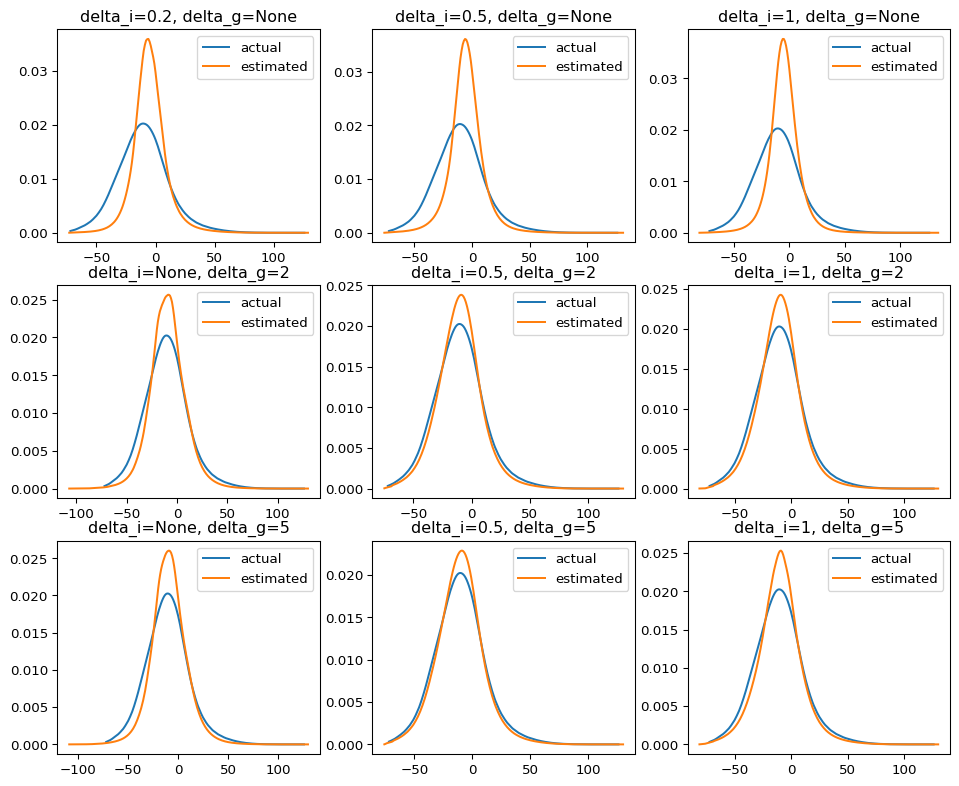

In [86]:
ns = [
    (0.2, None),
    (0.5, None),
    (1, None),
    (None, 2),
    (0.5, 2),
    (1, 2),
    (None, 5),
    (0.5, 5),
    (1, 5)
]
x = ('caf', 1993)


do_plot3(x, ns, get_neighbors_rectangle2)